# Auto Fringe Tracing - Fourier (Circular Fringes)

Thomas Varnish, 2020 (Adapted from template originally written by Jack Hare)

Start by loading the relevant libraries. (We call `%matplotlib notebook` to ensure all the plots are interactive.)

In [ ]:
# Uncomment if you don't have magpie_tools/code in your PYTHONPATH
# import sys
# sys.path.append("C:\\Users\\User\\Documents\\magpie_tools\\code")

In [2]:
%matplotlib notebook

from fringe_tracing_fourier import *
from skimage.filters import gaussian
import imageio
from copy import copy

import fringe_tracing_smoothing as ft  # Loaded for: save_file, save_file_alpha, load_file, plot_compare

## Load up the interferograms
On Windows, you can Shift + Right-Click a folder and choose "Copy as Path". Enter the path where the interferogram images are stored (into the `%cd` command).

We start with the background because it gives us good default values for the shot interferogram.

Copy the interferogram file name into `interferogram_fn`. 

Next, we load the interferogram and convert it to grayscale.

In [4]:
interferogram, interferogram_fn = ft.load_file("./example_data/s0823_18 355 nm g16 bk.jpg")

### Normalise the interferogram
We correct for variations in brightness by dividing the interferogram by a blurred version of itself. Choose the smallest value for blur such that no fringes are visible - it will be around the width of two fringes in pixels.

The blurred interferogram gives us (most of) the slowly varying, low frequency noise. Essentially, we're applying a high pass filter to the image before we proceed with extracting the fringes.

Make sure to zoom in on the blurred image to ensure there aren't any fringes visible.

<IPython.core.display.Javascript object>


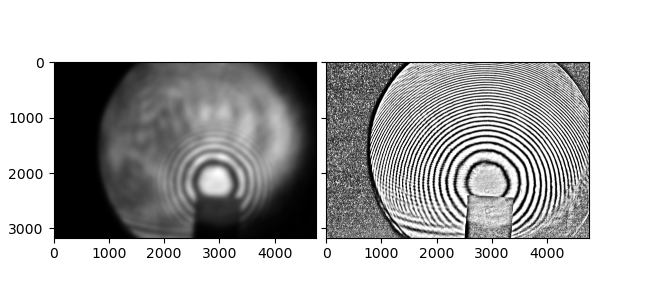

(<matplotlib.image.AxesImage at 0x24b8e634220>,
 <matplotlib.image.AxesImage at 0x24b8e634310>)

In [5]:
blur = 40

blurred_interferogram = gaussian(interferogram, blur)
normalised_interferogram = interferogram / blurred_interferogram

clip = [0.3, 1.2]
clipped_interferogram = (np.clip(normalised_interferogram, a_min=clip[0], a_max=clip[1])-clip[0])/(clip[1]-clip[0])

fig = plt.figure(figsize=(6.69, 3))
ft.plot_compare(fig, blurred_interferogram, clipped_interferogram)

#### Saving the clipped Interferogram
Enter the path where you want to store the clipped interferogram (for reference when tracing any missed fringes), and any processed data. This should probably be in a different location to where the raw interferograms are stored.

In [6]:
%cd "C:\Users\tvarnish\Desktop"

ft.save_file(interferogram_fn + " enhanced", clipped_interferogram)

C:\Users\tvarnish\Desktop


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


### Taking the FFT of the Interferogram
Once you're happy with the blurred interferogram, check out the Fourier transform of the normalised interferogram. Zoom in on the centre of the image - there should be a bright blob at the centre, and feinter patches extending into a (roughly) circular region around the central point. This ring around the central point contains the information about the circular fringes (repeating patterns in all directions), and we'll get rid of all the other data.

For reference, a polar grid (rings spaced radially by 10, and radial lines spaced by 10 degrees) is placed on top of the FFT image. You can use this to estimate the parameters needed for the filter.

<IPython.core.display.Javascript object>


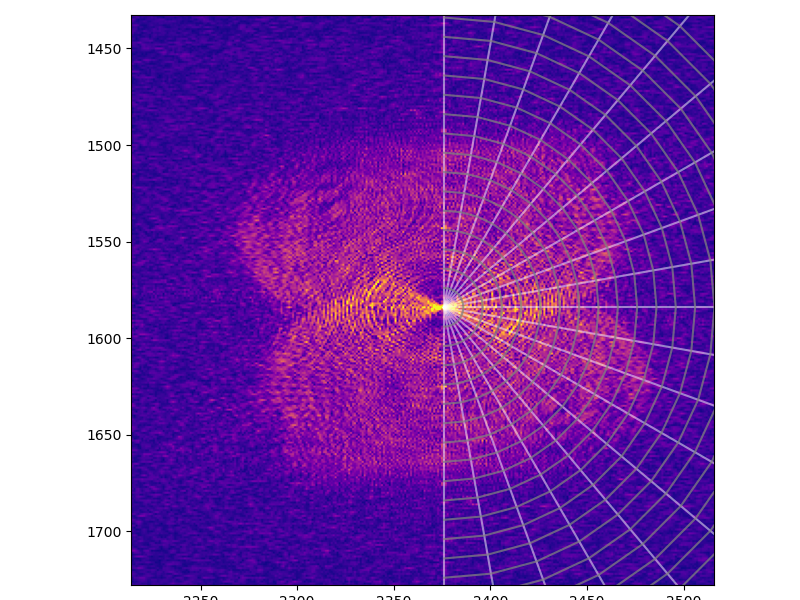

In [7]:
fft_image = (np.fft.fftshift(np.fft.fft2(normalised_interferogram)))

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(abs(fft_image), cmap="plasma", clim=[0, 100000])


# Draw the polar reference grid
y_size, x_size = fft_image.shape
mid_x, mid_y = x_size / 2.0, y_size / 2.0

for angle in range(-90, 100, 10):
    R = 300
    dx, dy = R * np.cos(angle * np.pi/180.0), R * np.sin(angle * np.pi/180.0)
    ax.plot([mid_x, mid_x + dx], [mid_y, mid_y - dy], '-', color="white", alpha=0.5)
    
for r in range(10, 200, 10):
    line_x = []
    line_y = []
    for angle in range(-90, 100, 10):
        dx, dy = r * np.cos(angle * np.pi/180.0), r * np.sin(angle * np.pi/180.0)
        line_x.append(mid_x + dx)
        line_y.append(mid_y - dy)
    ax.plot(line_x, line_y, '-', color="gray", alpha=0.75)
    
fig.tight_layout()

### Select a region from the Fourier image
By changing the variables `RING_INNER` and `RING_OUTER` below (second code block below), select the important parts of the Fourier image. The mask consists of a donut-shaped mask, excluding the region less than `RING_INNER` and further out than `RING_OUTER`.

In general, you want the smallest circles that are centered on the two bright spots in the Fourier image, with a little blur (eg. 20% of the filter radius).

Note: the angle `theta` is measured from the vertical, going clockwise. `R0` is measured from the central FFT point. See the previous plot shows an overlaid quadrant of these polar coordinates. Each line (increasing `theta`) represents 10 degrees. Each ring (increasing `R0`) represents 10 (pixels).

In [8]:
def circular_mask(data, radius, subtract=False):
    """ 
    Create a circular mask, centred on the centre of the FFT image. 
    data: fft image (used to get shape)
    radius: max. extent of the mask out from the centre
    subtract (bool): if true, the region described by the circle is removed, and the rest of the image is kept.
    """
    
    h, w = data.shape
    Y, X = np.ogrid[:h, :w]
    
    centre = (int(w / 2), int(h / 2))
    dist_from_centre = np.sqrt((X - centre[0]) ** 2 + (Y - centre[1]) ** 2)

    mask = (dist_from_centre <= radius)
    
    if subtract is True:
        mask = mask == 0

    mask = mask.astype(int)

    return mask

def ring_mask(data, min_r, max_r):
    """
    Create a (donut-shaped) ring mask. Any data closer to the centre than min_r or further than max_r is removed.
    """
    
    outer_mask = circular_mask(data, max_r)
    inner_mask = circular_mask(data, min_r, subtract=True)
    
    return outer_mask * inner_mask

Creat a "donut" slice of the FFT image. Remove low frequency noise near the central point, and try to cover (most) of the outer lobes. It can sometimes be useful to trim off the outer edges of the lobes.

<IPython.core.display.Javascript object>


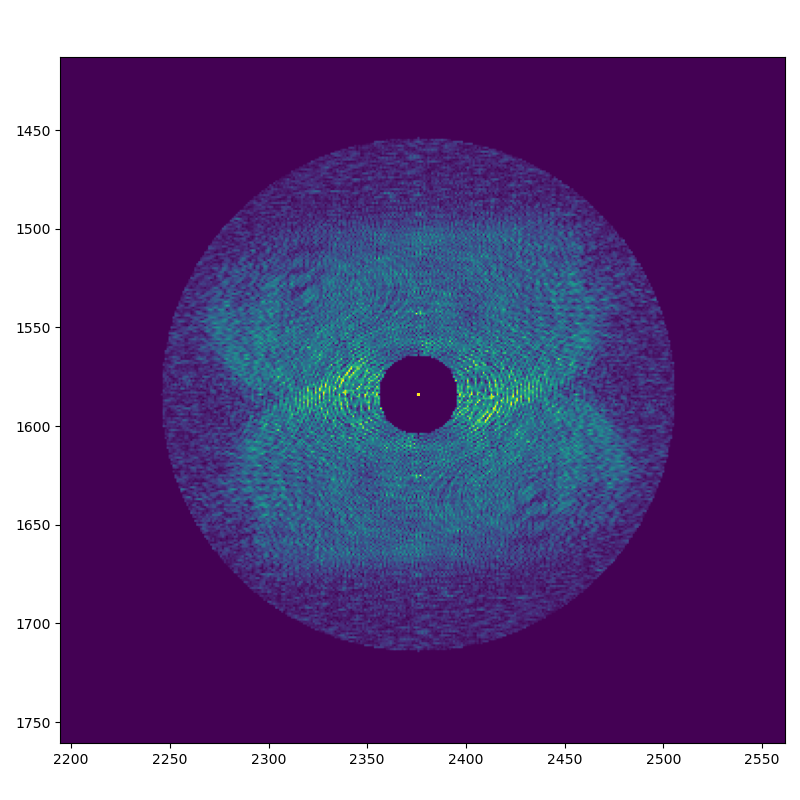

In [18]:
RING_INNER = 20
RING_OUTER = 130

# Create filter
fft_filter = ring_mask(np.abs(fft_image), RING_INNER, RING_OUTER)

# Allow DC average value through the filter
fft_filter[fft_filter.shape[0]//2, fft_filter.shape[1]//2] = 1

masked_fft = fft_filter * fft_image

# Display filtered FFT image
fig, ax=plt.subplots(1, 1, figsize=(8,8))

ax.imshow(np.abs(masked_fft[:,:]), clim=[0, 100000])
fig.tight_layout()

### Create the Fourier-filtered Interferogram
Once you're happy with the region of Fourier space you're keeping in the above cell, it's time to do the inverse Fourier transform and look at the resulting interferogram.
This interferogram will only contain fringes aligned with the predominant fringe pattern, and it doesn't include the high frequency modulations seen in the beam.

For circular fringes, the trace isn't going to be perfect. Often there'll be small spurs on the fringes or gaps. Unfortunately, you'll have to just correct these by hand in Photoshop. On the upside, most of the interferogram should be (reasonably well) traced so the whole process should at least be slightly quicker than tracing the whole thing by hand!

<IPython.core.display.Javascript object>


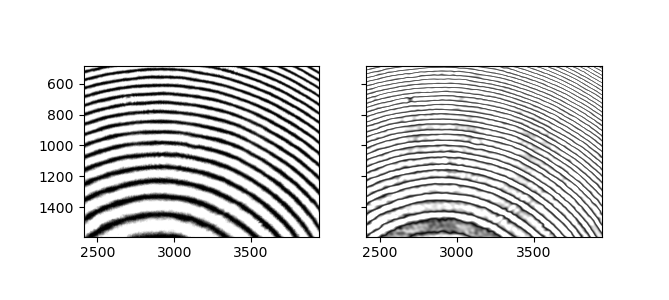

In [19]:
# Filter the FFT image using the paramters chosen above
fft_filter = ring_mask(np.abs(fft_image), RING_INNER, RING_OUTER)
masked_fft = fft_filter * fft_image

# Take the inverse FFT of the filtered FFT image
ifft_image = abs((np.fft.ifft2(masked_fft)))

# fig, ax = plt.subplots(figsize=(6.69, 3))
# ax.imshow(ifft_image, cmap='gray', clim=[0, 0.4])
fig, ax = plt.subplots(1, 2, figsize=(6.69, 3), sharex=True, sharey=True)
ax[1].imshow(ifft_image, cmap='gray', clim=[0, 0.5])
ax[0].imshow(clipped_interferogram, cmap="gray")

### Threshold the filtered image
Now we need to conver this interferogram to a binary black or white image. Then an algorithm reduces these black and white fringes to one pixel thick lines for Magic2.

First, change a threshold so it is approximately the value halfway between a dark and a bright fringe - something like 0.1-0.3 usually works. Then run the cell. A PNG file will be created in the processed data folder (where the enhanced interferogram is saved), with the same file name + 'traced'.

Zoom in on the traced interferogram plot and inspect it. If the fringes don't extend as far as you'd like, then decrease the threshold value. If the fringes are joined by short perpendicular fringes, increase the threshold value. Keep editing the threshold value and running this cell until you're happy with the result.

<IPython.core.display.Javascript object>


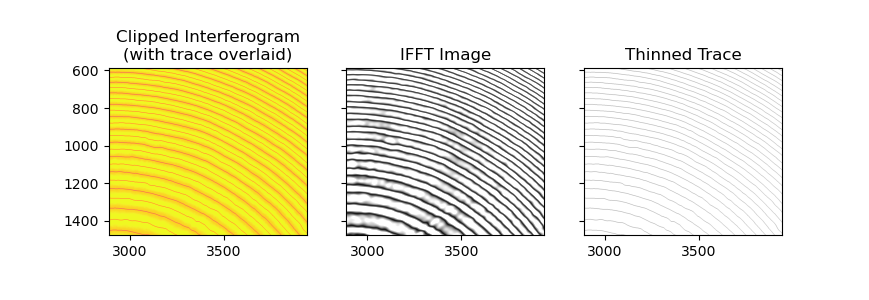

Text(0.5, 1.0, 'Thinned Trace')

In [27]:
threshold_value = 0.3

# Set to True if you'd like the bright fringes traced, or set to False to trace the dark fringes
trace_bright = True

if trace_bright:
    bwimage = ifft_image > threshold_value
else:
    bwimage = ifft_image < threshold_value

imthin = thin(bwimage, max_num_iter=1000)
invert = 1 - imthin

fig, ax = plt.subplots(1, 3, figsize=(8.69, 3), sharex=True, sharey=True)
ax[0].imshow(clipped_interferogram + (invert * 10), cmap="plasma")  # Overlay trace by shifting it higher in color map.
ax[0].set_title("Clipped Interferogram\n(with trace overlaid)")
ax[1].imshow(ifft_image, cmap='gray', clim=[0, 0.5])
ax[1].set_title("IFFT Image")
ax[2].imshow(invert, cmap="gray")
ax[2].set_title("Thinned Trace")

#### Save the traced interferogram file
Again, enter the path where you want to store the traced interferogram (in `%cd`).

To convert the black-and-white image to a black-and-transparent image, we set all white values to False (transparent when using `save_file_alpha`) and then invert the image to ensure the lines are black not white.

In [30]:
%cd "C:\Users\tvarnish\Desktop"

# Save the "transparent version" (for using with Photoshop and combining with a mask)
output_fn = interferogram_fn + " traced"

transparent = (invert == 0)

if trace_bright is True:
    output_fn += " (bright)"
else:
    output_fn += " (dark)"
        
ft.save_file_alpha(output_fn, transparent, invert=True)
        
# Save the blur, fft, and threshold parameters in a log file
with open(interferogram_fn + " log.txt", "w") as f:
    f.write("=== Fourier Auto-tracing Parameters (Circular Fringes) ===\n")
    f.write(interferogram_fn + "\n\n")
    
    f.write("gaussian blur: " + str(blur) + "\n")
    f.write("clip: (" + str(clip[0]) + ", " + str(clip[1]) + ")\n")
    f.write("RING_INNER: " + str(RING_INNER) + "\n")
    f.write("RING_OUTER: " + str(RING_OUTER) + "\n")
    f.write("threshold value: " + str(threshold_value))
    
    # Write whether the bright (or dark) fringes were traced to log
    if trace_bright is True:
        traced = "bright"
    else:
        traced = "dark"
    f.write("traced: " + traced + "\n")

C:\Users\tvarnish\Desktop


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


#### Auto-tracing the shot interferogram
Go back to the top, and edit the filename so it points to the shot interferogram. Work through all the cells in order. When you get to choosing the region of interest in the Fourier image, the values you used for the background interferogram will be loaded as the initial region. 

Now you might want to expand the radius of the circles to include more of the Fourier image, as fringes which are slightly bent will be in a region nearby to initial region. Do the inverse Fourier transform, check that most of the fringes are still present, and then threshold and save out the image - experiment with a different threshold value to maximise the number of auto-traced fringes.

#### How to use these images in photoshop
1. Open one of the raw interferograms in Photoshop.
2. Place the other raw interferogram and the two traced interferograms as layers. (To add/move more layers you might need to save the file as a .psd at this point.)
3. Layer -> Rasterize all layers (or right click on each layer and select Rasterize)
4. Layer -> Layer style -> Colour Overlay, and choose a contrasting colour so traced fringes show up on bright and dark regions of interferogram. (To see the new colour, you may need to change Image -> Mode to RGB (rather than Gray).)
5. Use the eraser to remove fringes that have been traced wrongly
6. Create a mask using the pen tool in the standard way
7. Draw new fringes using the pen tool, stroke with a 1 px black pencil onto the appropriate traced interferogram layer. (Make sure the active colour is set to black, despite having the colour overlay active.)
8. Place a white layer beneath the traced interferogram layer.
9. Use the threshold adjustment layer tool (Layer -> New Adjustment Layer) to ensure the lines are black (threshold 255)
10. Save as PNG and load with Magic2.